In [22]:
import sys 
sys.path.append("/Users/dianaholcomb/Desktop/GWU/6203_Machine_Learning_II/workspace3.5/xView_data_utilities/")
import aug_util as aug
import matplotlib.pyplot as plt
import numpy as np
import csv
from PIL import Image
import json
from tqdm import tqdm
%matplotlib inline

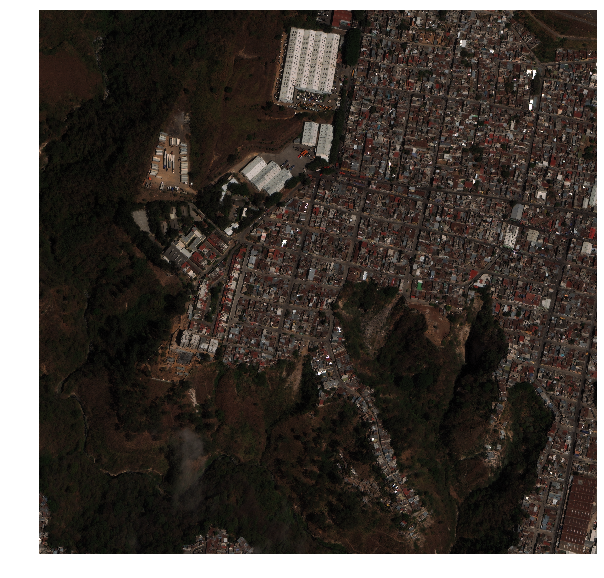

In [78]:
#Load an image
chip_path = '../xView/train_images/'
chip_name = '2355.tif'
arr = wv.get_image(chip_path + chip_name)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(arr)

In [73]:
def scale(x,range1=(0,0),range2=(0,0)):
    """
    Linear scaling for a value x
    """
    return range2[0]*(1 - (x-range1[0]) / (range1[1]-range1[0])) + range2[1]*((x-range1[0]) / (range1[1]-range1[0]))


def get_image(fname):    
    """
    Get an image from a filepath in ndarray format
    """
    return np.array(Image.open(fname))


def get_labels(fname):
    """
    Gets label data from a geojson label file

    Args:
        fname: file path to an xView geojson label file

    Output:
        Returns three arrays: coords, chips, and classes corresponding to the
            coordinates, file-names, and classes for each ground truth.
    """
    with open(fname) as f:
        data = json.load(f)

    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))

    for i in tqdm(range(len(data['features']))):
        if(data['features'][i]['properties']['image_id'] == '2355.tif'):
            #print(data['features'][i]['properties'])
            test = True
        if data['features'][i]['properties']['bounds_imcoords'] != []:
            b_id = data['features'][i]['properties']['image_id']
            val = np.array([int(num) for num in data['features'][i]['properties']['bounds_imcoords'].split(",")])
            #print(val)
            chips[i] = b_id
            classes[i] = data['features'][i]['properties']['type_id']
            if val.shape[0] != 4:
                print("Issues at %d!" % i)
            else:
                coords[i] = val
        else:
            chips[i] = 'None'


    return coords, chips, classes


def boxes_from_coords(coords):
    """
    Processes a coordinate array from a geojson into (xmin,ymin,xmax,ymax) format

    Args:
        coords: an array of bounding box coordinates

    Output:
        Returns an array of shape (N,4) with coordinates in proper format
    """
    nc = np.zeros((coords.shape[0],4))
    for ind in range(coords.shape[0]):
        x1,x2 = coords[ind,:,0].min(),coords[ind,:,0].max()
        y1,y2 = coords[ind,:,1].min(),coords[ind,:,1].max()
        nc[ind] = [x1,y1,x2,y2]
    return nc


def chip_image(img,coords,classes,shape=(300,300)):
    """
    Chip an image and get relative coordinates and classes.  Bounding boxes that pass into
        multiple chips are clipped: each portion that is in a chip is labeled. For example,
        half a building will be labeled if it is cut off in a chip. If there are no boxes,
        the boxes array will be [[0,0,0,0]] and classes [0].
        Note: This chip_image method is only tested on xView data-- there are some image manipulations that can mess up different images.

    Args:
        img: the image to be chipped in array format
        coords: an (N,4) array of bounding box coordinates for that image
        classes: an (N,1) array of classes for each bounding box
        shape: an (W,H) tuple indicating width and height of chips

    Output:
        An image array of shape (M,W,H,C), where M is the number of chips,
        W and H are the dimensions of the image, and C is the number of color
        channels.  Also returns boxes and classes dictionaries for each corresponding chip.
    """
    height,width,_ = img.shape
    wn,hn = shape
    
    w_num,h_num = (int(width/wn),int(height/hn))
    images = np.zeros((w_num*h_num,hn,wn,3))
    total_boxes = {}
    total_classes = {}
    
    k = 0
    for i in range(w_num):
        for j in range(h_num):
            x = np.logical_or( np.logical_and((coords[:,0]<((i+1)*wn)),(coords[:,0]>(i*wn))),
                               np.logical_and((coords[:,2]<((i+1)*wn)),(coords[:,2]>(i*wn))))
            out = coords[x]
            y = np.logical_or( np.logical_and((out[:,1]<((j+1)*hn)),(out[:,1]>(j*hn))),
                               np.logical_and((out[:,3]<((j+1)*hn)),(out[:,3]>(j*hn))))
            outn = out[y]
            out = np.transpose(np.vstack((np.clip(outn[:,0]-(wn*i),0,wn),
                                          np.clip(outn[:,1]-(hn*j),0,hn),
                                          np.clip(outn[:,2]-(wn*i),0,wn),
                                          np.clip(outn[:,3]-(hn*j),0,hn))))
            box_classes = classes[x][y]
            
            if out.shape[0] != 0:
                total_boxes[k] = out
                total_classes[k] = box_classes
            else:
                total_boxes[k] = np.array([[0,0,0,0]])
                total_classes[k] = np.array([0])
            
            chip = img[hn*j:hn*(j+1),wn*i:wn*(i+1),:3]
            images[k]=chip
            
            k = k + 1
    
    return images.astype(np.uint8),total_boxes,total_classes


In [79]:
coords, chips, classes = get_labels('../xView/xView_train.geojson')

100%|██████████| 601937/601937 [00:03<00:00, 178265.52it/s]


In [80]:
#We only want to coordinates and classes that are within our chip
coords = coords[chips==chip_name]
classes = classes[chips==chip_name].astype(np.int64)
print(coords)
print(classes)

['2355.tif' '2355.tif' '2355.tif' ... '389.tif' '389.tif' '389.tif']
2355.tif
(array([   0,    1,    2, ..., 2345, 2346, 2347]),)
[[2712. 1145. 2746. 1177.]
 [2720. 2233. 2760. 2288.]
 [2687. 1338. 2740. 1399.]
 ...
 [1789. 1335. 1803. 1349.]
 [1296.  449. 1318.  471.]
 [1451.  311. 1464.  318.]]
[73 73 73 ... 18 64 18]


In [81]:
#Load the class number -> class string label map
labels = {}
with open('xview_class_labels.txt') as f:
    for row in csv.reader(f):
        labels[int(row[0].split(":")[0])] = row[0].split(":")[1]

In [82]:
#We can find which classes are present in this image
print([labels[i] for i in np.unique(classes)])

['Small Aircraft', 'Small Car', 'Bus', 'Pickup Truck', 'Utility Truck', 'Cargo Truck', 'Truck w/Box', 'Truck Tractor', 'Trailer', 'Truck w/Flatbed', 'Dump Truck', 'Excavator', 'Building', 'Facility', 'Vehicle Lot', 'Shipping container lot']
[73 73 73 ... 18 64 18]
[[2712. 1145. 2746. 1177.]
 [2720. 2233. 2760. 2288.]
 [2687. 1338. 2740. 1399.]
 ...
 [1789. 1335. 1803. 1349.]
 [1296.  449. 1318.  471.]
 [1451.  311. 1464.  318.]]
['2355.tif' '2355.tif' '2355.tif' ... '389.tif' '389.tif' '389.tif']


In [83]:
#We can chip the image into 500x500 chips
c_img, c_box, c_cls = chip_image(img = arr, coords= coords, classes=classes, shape=(500,500))
print("Num Chips: %d" % c_img.shape[0])

Num Chips: 25


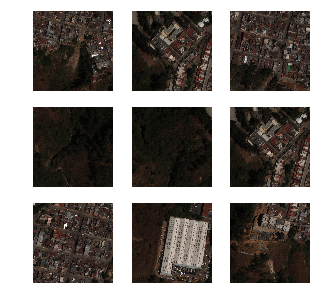

In [84]:
#We can plot some of the chips
fig,ax = plt.subplots(3)
fig.set_figheight(5)
fig.set_figwidth(5)

for k in range(9):
    plt.subplot(3,3,k+1)
    plt.axis('off')
    plt.imshow(c_img[np.random.choice(range(c_img.shape[0]))])

plt.show()

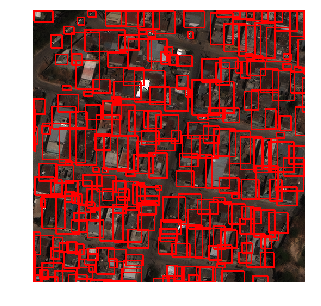

In [85]:
#We can visualize the chips with their labels
ind = np.random.choice(range(c_img.shape[0]))
labelled = aug.draw_bboxes(c_img[ind],c_box[ind])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(labelled)

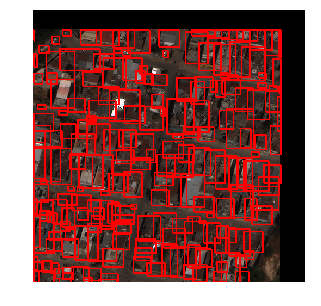

In [86]:
#We can shift the chips
i1,b1 = aug.shift_image(c_img[ind],c_box[ind])
a1 = aug.draw_bboxes(i1,b1)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a1)

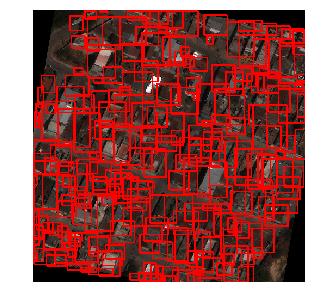

In [87]:
#We can rotate the chips
center = (int(c_img[ind].shape[0]/2),int(c_img[ind].shape[1]/2))
i2,b2 = aug.rotate_image_and_boxes(c_img[ind],10, center, c_box[ind])
a2 = aug.draw_bboxes(i2,b2)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a2)

In [11]:
#There are other augmentations available in 'aug_util.py'
#From here, you can save out the chipped images to a TFRecord or other medium
#Use 'process_wv.py' to create a TFRecord file from xView imagery